# Библиотеки

In [345]:

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
import scipy.stats as stats

# Исходный набор данных

In [312]:
data = pd.read_csv('example_data',sep=',')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(by= 'timestamp')
data

,user_id,timestamp,event
0,148870bfa84777898359aaa8e120a373,2021-01-01 00:00:01.000000000,landing
1,ac3948ea43cb39cdc4e739004d252d0b,2021-01-01 00:00:01.445020335,landing
2,48a0df50d7ed1fcaaddf742b828b85e5,2021-01-01 00:00:10.566157670,login
3,70fbdd335abb11a3d072b5de7b218048,2021-01-01 00:00:10.764937005,main
4,48a0df50d7ed1fcaaddf742b828b85e5,2021-01-01 00:00:10.764937005,login
...,...,...,...
1040166,a63250880822c619ecbbf9fa511d31cd,2021-04-07 13:20:16.775249492,login
1040167,7fa83873bead5c5a52d6805570aba31d,2021-04-07 13:20:18.688737570,registration
1040168,1d716213d6f611f80592391ac61b5a5c,2021-04-07 13:20:18.688737570,main
1040169,7fa83873bead5c5a52d6805570aba31d,2021-04-07 13:20:22.134689896,registration


На данной странице фиксируется 5 событий:
 - landing: Событие, связанное с попаданием на landing page. Это веб-страница, на которую пользователь попадает после нажатия на определенную ссылку или рекламный баннер. Она является первым контактом пользователя с веб-сайтом или кампанией и предназначена для привлечения его внимания.
 - login: Событие, связанное с процессом входа пользователя в систему.
 - main: Событие, связанное с основным содержимым или главной страницей приложения/сайта.
 - registration: Событие, связанное с процессом регистрации пользователя.
 - registration_new: Событие, связанное с процессом регистрации пользователя на новой странице.


In [313]:
data.dtypes

user_id              object
timestamp    datetime64[ns]
event                object
dtype: object

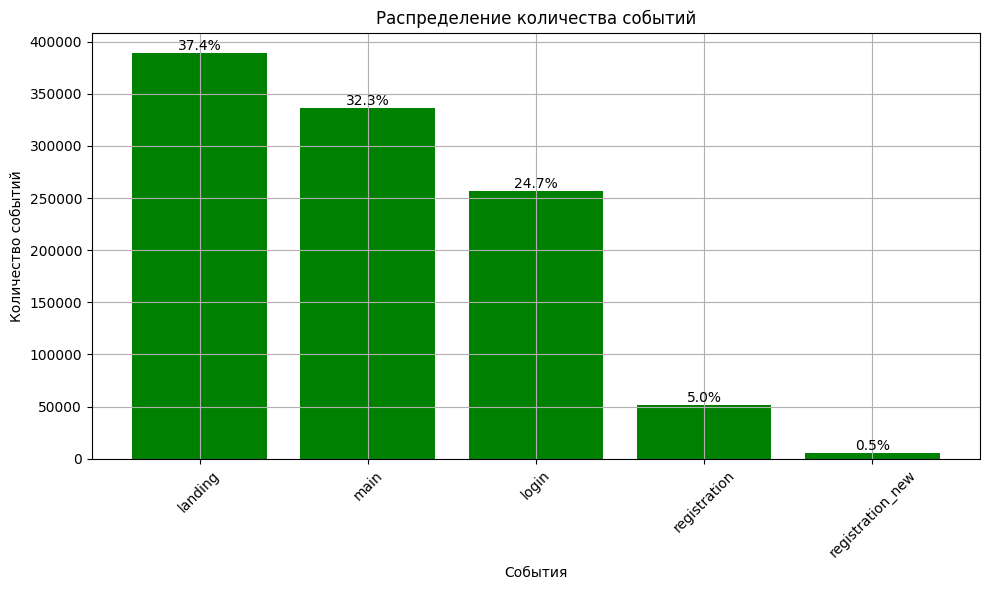

In [314]:
event_counts = data['event'].value_counts()

plt.figure(figsize=(10, 6))  
plt.grid(True)  
plt.bar(event_counts.index, event_counts.values, color='green')  
plt.xlabel('События')
plt.ylabel('Количество событий')
plt.title('Распределение количества событий')

total_events = len(data)
for i, count in enumerate(event_counts.values):
    percentage = (count / total_events) * 100
    plt.text(i, count, f"{percentage:.1f}%", ha='center', va='bottom')

plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()


Отфильтруем данные от пользователей, у которых за весь исследуемый период было всего одно обращение к веб-сервису.

In [315]:
data = data.groupby('user_id').filter(lambda x: len(x) > 1)
data

,user_id,timestamp,event
2,48a0df50d7ed1fcaaddf742b828b85e5,2021-01-01 00:00:10.566157670,login
3,70fbdd335abb11a3d072b5de7b218048,2021-01-01 00:00:10.764937005,main
4,48a0df50d7ed1fcaaddf742b828b85e5,2021-01-01 00:00:10.764937005,login
5,70fbdd335abb11a3d072b5de7b218048,2021-01-01 00:00:26.757563301,main
6,48a0df50d7ed1fcaaddf742b828b85e5,2021-01-01 00:00:30.111507967,main
...,...,...,...
1040166,a63250880822c619ecbbf9fa511d31cd,2021-04-07 13:20:16.775249492,login
1040167,7fa83873bead5c5a52d6805570aba31d,2021-04-07 13:20:18.688737570,registration
1040168,1d716213d6f611f80592391ac61b5a5c,2021-04-07 13:20:18.688737570,main
1040169,7fa83873bead5c5a52d6805570aba31d,2021-04-07 13:20:22.134689896,registration


## Найдем топ наиболее активных пользователей и посмотрим визуально распределение 

In [316]:
active_users = data['user_id'].value_counts().head(5)

print(active_users)

user_id
c9be7da3b5c975cc2795f15d45f0390a    5130
e7dcf0579c9e5cd13e881e44510d03a6    2595
6259ded656abc545d040af215e4ddcc6    2071
ffc3b3cc40797a17766c625212748fe5    1465
41b34f6d4c55db356afafff81abccd36    1343
Name: count, dtype: int64


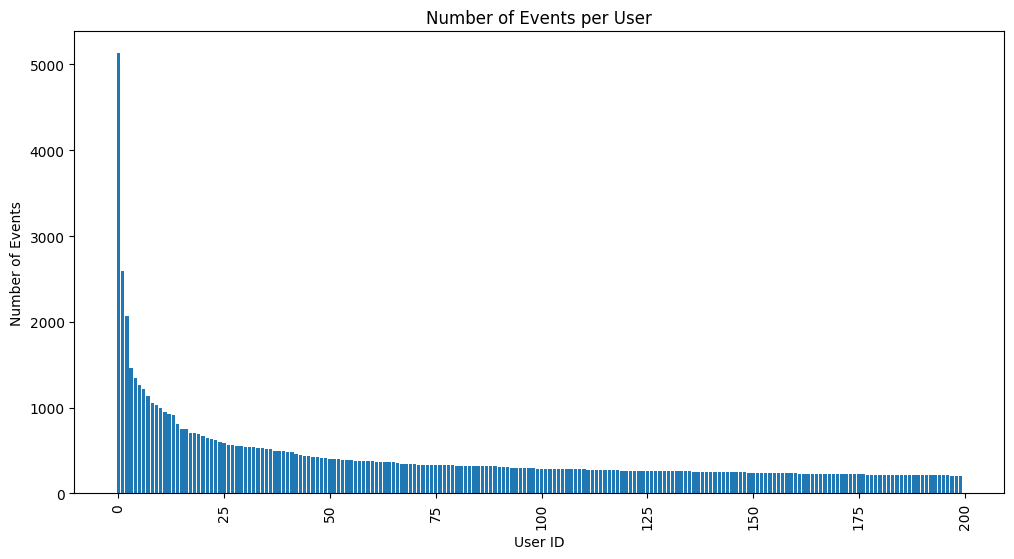

In [317]:
active_users = data['user_id'].value_counts().head(200)
plt.figure(figsize=(12, 6))
plt.bar(range(len(active_users)), active_users.values)

plt.xlabel('User ID')
plt.ylabel('Number of Events')
plt.title('Number of Events per User')

plt.xticks(rotation=90)

plt.show()

Заметим, что есть один клиент с наибольшим количеством запросов на странице, количество запросов на страницу экспоненциально падает.

#  Оценим трафик на сайте

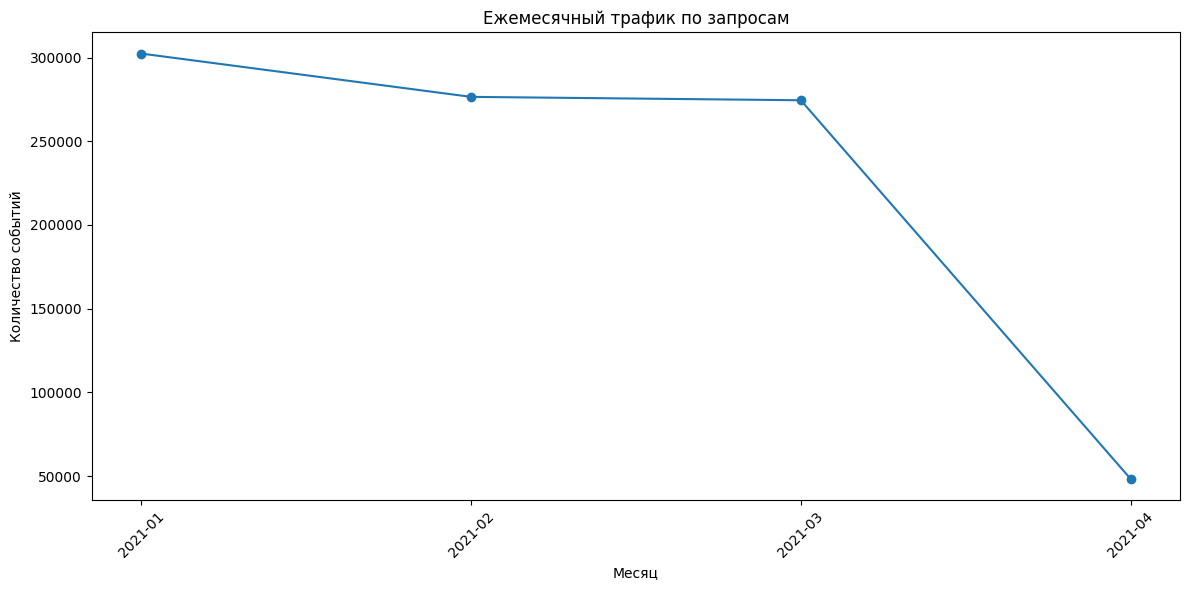

In [318]:
monthly_traffic = data.groupby(data['timestamp'].dt.to_period('M'))['event'].count()
monthly_traffic.index = monthly_traffic.index.astype(str)

plt.figure(figsize=(12, 6))
plt.plot(monthly_traffic.index, monthly_traffic.values, marker='o')
plt.xlabel('Месяц')
plt.ylabel('Количество событий')
plt.title('Ежемесячный трафик по запросам')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

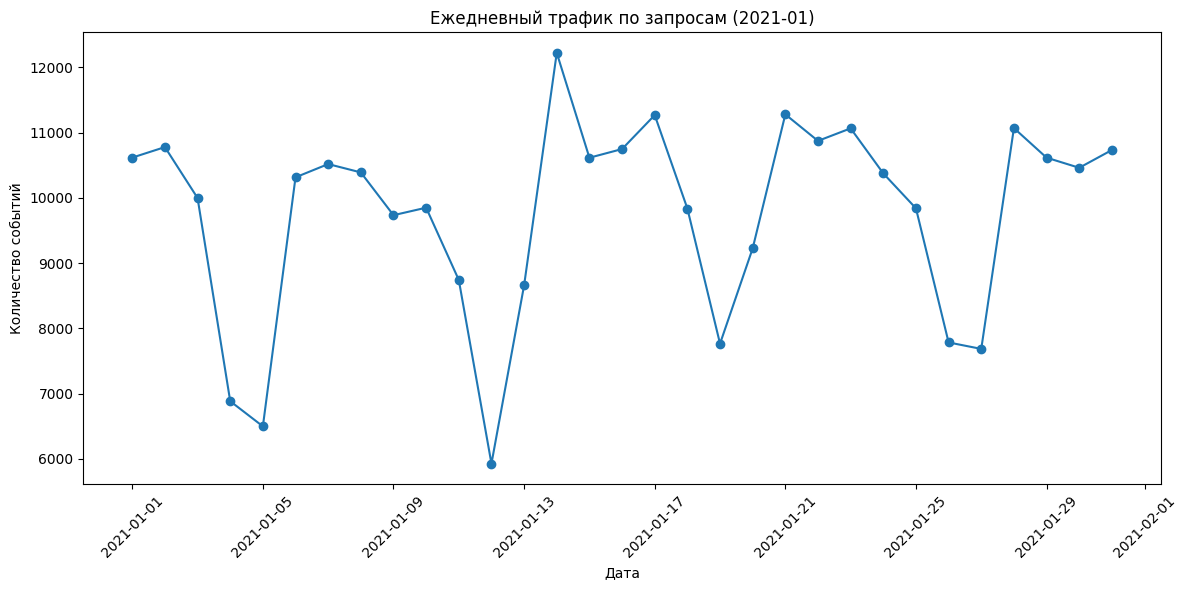

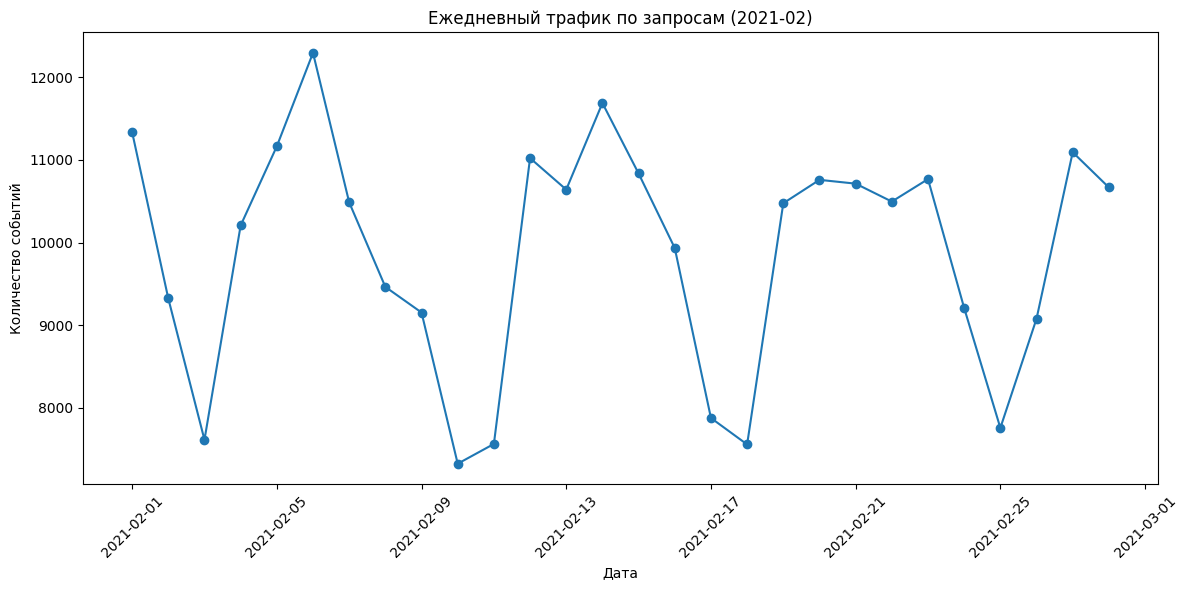

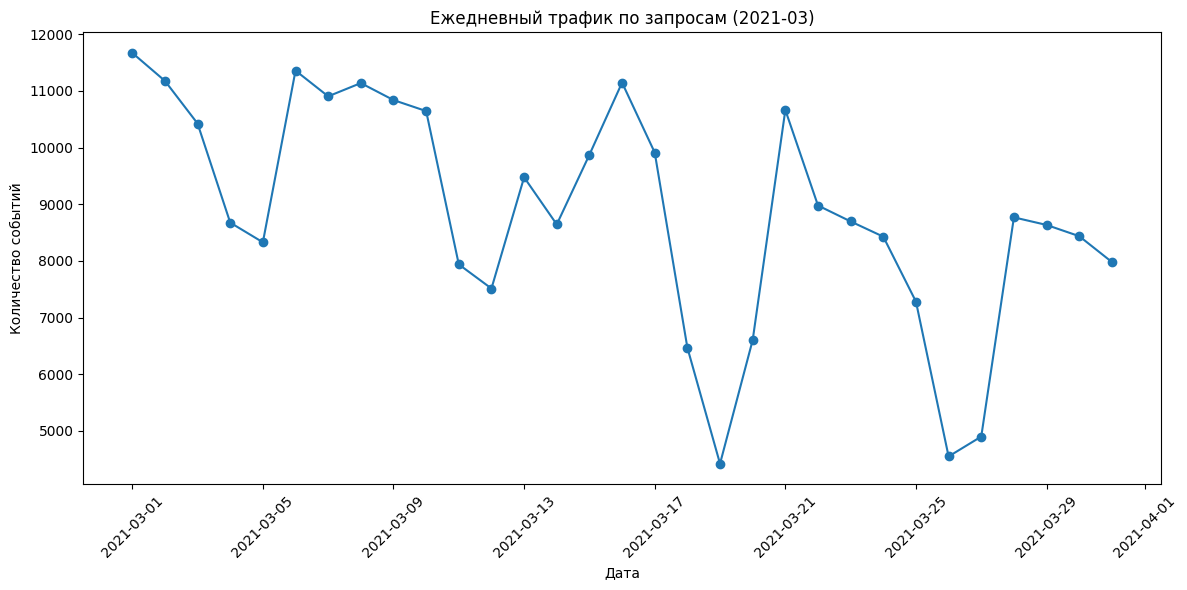

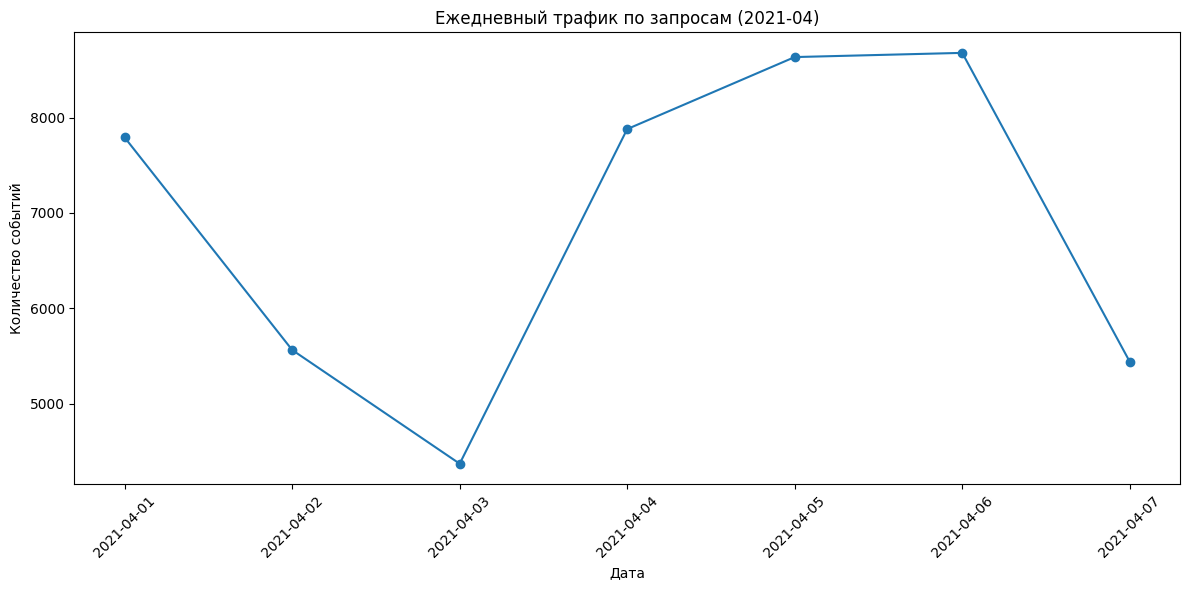

In [319]:
for year_month, group in data.groupby(data['timestamp'].dt.to_period('M')):
    monthly_traffic = group.groupby(group['timestamp'].dt.date)['event'].count()

    
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_traffic.index, monthly_traffic.values, marker='o')
    plt.xlabel('Дата')
    plt.ylabel('Количество событий')
    plt.title(f'Ежедневный трафик по запросам ({year_month})')

    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


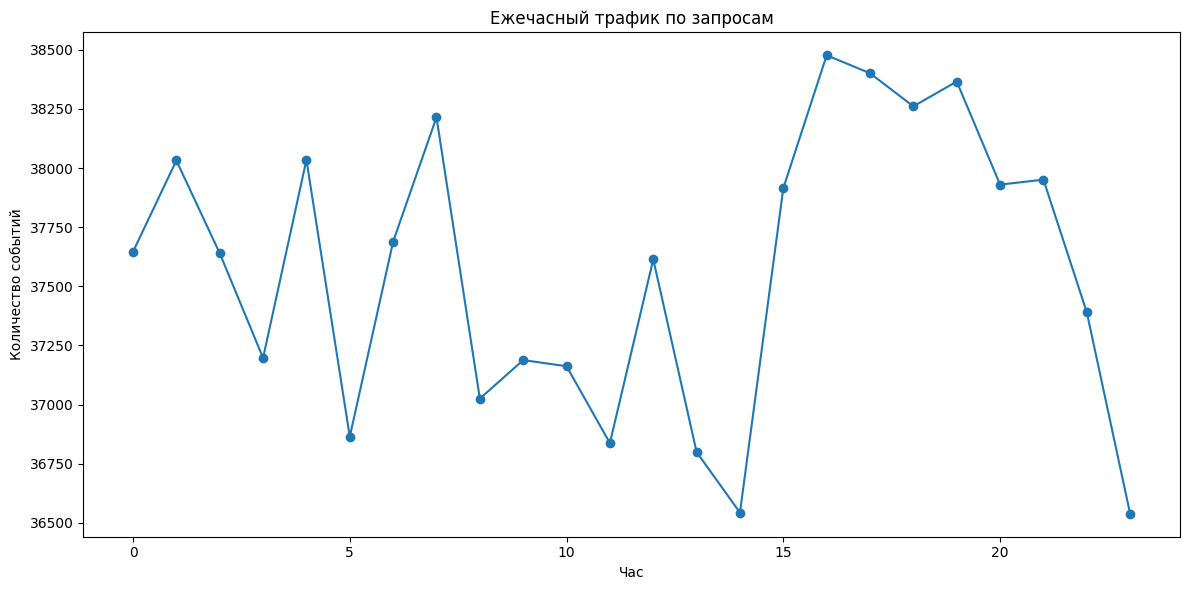

In [320]:

hourly_traffic = data.groupby(data['timestamp'].dt.hour)['event'].count()


plt.figure(figsize=(12, 6))
plt.plot(hourly_traffic.index, hourly_traffic.values, marker='o')
plt.xlabel('Час')
plt.ylabel('Количество событий')
plt.title('Ежечасный трафик по запросам')

plt.tight_layout()
plt.show()

- Видим, что наибольшее количество обращений к странице было в январе, затем количество запросов падает, в феврале и марте примерно н на одном уровне, затем в апреле резкое падение из-за неполного набора данных за месяц.
- Заметна одинаковая внутримесяная тенденция. Количество обращений к странице падает к середине недели и возрастает к концу недели.
- Внутри дня наибольшая активность после 16.00. Наименьшее количество обращений во время рабочего дня (с 8.00 до 16.00).

# Исследование целевой задачи

In [321]:
registration_events = data[data['event'].isin(['registration', 'registration_new'])]
users_with_both_registrations = registration_events.groupby('user_id').filter(lambda x: set(x['event']) == {'registration', 'registration_new'})
unique_users = users_with_both_registrations['user_id'].unique()
print(unique_users)

[]


## Заметрим, что в выборке не было пользователей, которые были на обеих формах регистрации registration и registration_new. Таким образом, целесообразно разделить на два набора данных: в одном пользователи с registration, в другом с registration_new.

In [322]:
new_registration_users = data[data['event'] == 'registration_new']['user_id'].unique().tolist()
old_registration_users = data[data['event'] == 'registration']['user_id'].unique().tolist()
old_registration_data = data[data['user_id'].isin(old_registration_users)]
new_registration_data = data[data['user_id'].isin(new_registration_users)]
not_registration_data = data[(~data['user_id'].isin(old_registration_users)) & (~data['user_id'].isin(new_registration_users))]
not_registration_users = not_registration_data['user_id'].unique().tolist()

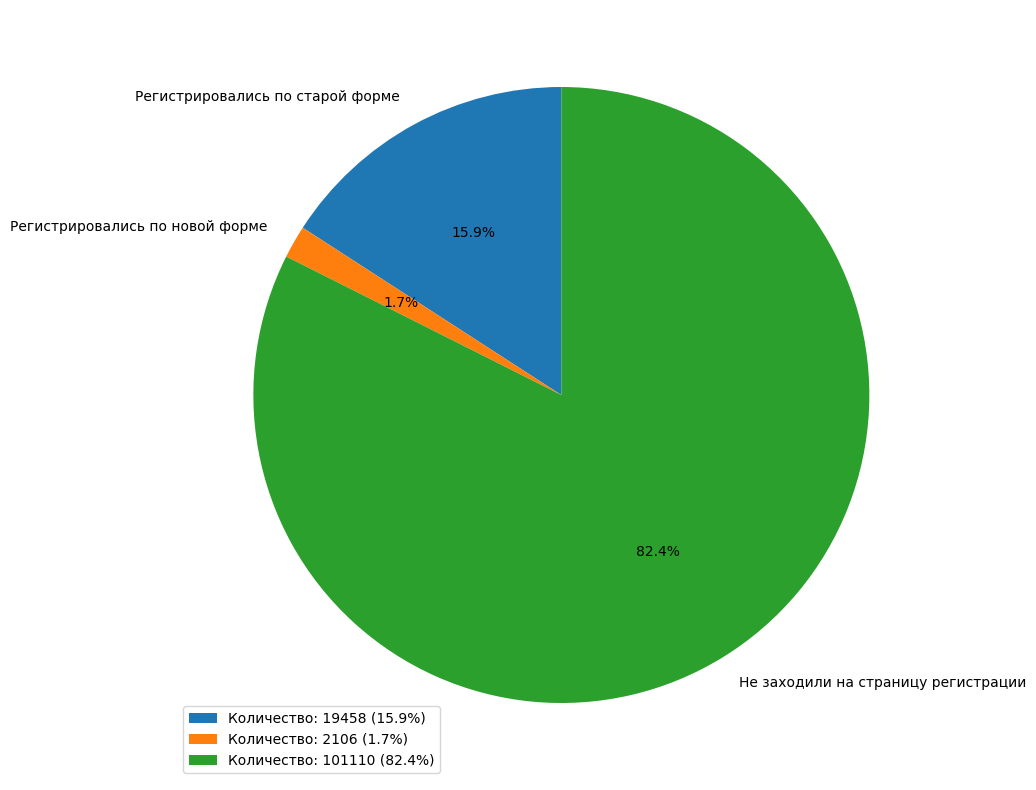

In [323]:
labels = ['Регистрировались по старой форме', 'Регистрировались по новой форме', 'Не заходили на страницу регистрации']
sizes = [len(old_registration_users)/len(data)*100, len(new_registration_users)/len(data)*100, len(not_registration_users)/len(data)*100]
counts = [len(old_registration_users), len(new_registration_users), len(not_registration_users)]


fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

ax.set_aspect('equal')  
total = sum(counts)
info = [f'Количество: {count} ({count/total*100:.1f}%)' for count in counts]
ax.legend(info, loc='lower left')

plt.show()

Заметим, что выборки сильно дизбалансированы. При этом целевых пользователей, посетивших новую форму регистрации 2074.

## Будем считать, что пользователь "активный", если после последнего обращения к форме регистрации у него было хотя бы одно обращение к форме login. То есть он авторизовывался под своим логином и парольом. Если количество login после регистриции равно нулю, то будем считать, что пользователь не смог пройти регистрацию.

In [324]:

last_registration_time = old_registration_data[old_registration_data['event'] == 'registration'].groupby('user_id')['timestamp'].max()


merged_data = pd.merge(old_registration_data, last_registration_time, on='user_id')


login_after_registration = merged_data[(merged_data['event'] == 'login') & (merged_data['timestamp_x'] > merged_data['timestamp_y'])]


users_with_multiple_login = login_after_registration['user_id'].unique()


old_registration_active = old_registration_data[old_registration_data['user_id'].isin(users_with_multiple_login)]
old_registration_left = old_registration_data[~old_registration_data['user_id'].isin(users_with_multiple_login)]


In [325]:
old_registration_active

,user_id,timestamp,event
8,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-01 00:00:44.500571856,main
55,3e206b79238ad9bbdc93a66c5eb6b4eb,2021-01-01 00:07:47.202408836,login
91,3ca4377617b12c3fd1198df1087c7281,2021-01-01 00:13:12.622705924,main
96,3e206b79238ad9bbdc93a66c5eb6b4eb,2021-01-01 00:13:56.004836937,main
99,c4564417e395764bc4f6c96acb848be7,2021-01-01 00:14:10.460863624,login
...,...,...,...
1040158,7f93c6311b323a43f22949bb3fa2d6ee,2021-04-07 13:18:50.939043436,landing
1040160,7f93c6311b323a43f22949bb3fa2d6ee,2021-04-07 13:18:55.594507525,landing
1040163,937c2729456b2ee911551f6ace6cfa79,2021-04-07 13:19:14.326403942,main
1040164,c9be7da3b5c975cc2795f15d45f0390a,2021-04-07 13:20:12.978721464,login


In [326]:
old_registration_left

,user_id,timestamp,event
11,4f2ba63e1426a17f3e089f30f3f3c737,2021-01-01 00:01:17.963347338,main
15,9dd45f60cfad85074fb3a964683f3c25,2021-01-01 00:01:31.095477978,registration
20,4f2ba63e1426a17f3e089f30f3f3c737,2021-01-01 00:01:57.940534377,main
49,aa5a9288105664c463aa32e014f00897,2021-01-01 00:07:11.830669390,landing
59,aa5a9288105664c463aa32e014f00897,2021-01-01 00:08:10.171425274,registration
...,...,...,...
1040101,7115174faf5414a66fd06ae14eee6c52,2021-04-07 13:11:41.447675415,registration
1040103,7115174faf5414a66fd06ae14eee6c52,2021-04-07 13:11:44.394924351,main
1040104,91e76a37ff8e6483709436e18671834c,2021-04-07 13:11:49.959265641,main
1040167,7fa83873bead5c5a52d6805570aba31d,2021-04-07 13:20:18.688737570,registration


In [327]:

last_registration_time = new_registration_data[new_registration_data['event'] == 'registration_new'].groupby('user_id')['timestamp'].max()


merged_data = pd.merge(new_registration_data, last_registration_time, on='user_id')


login_after_registration = merged_data[(merged_data['event'] == 'login') & (merged_data['timestamp_x'] > merged_data['timestamp_y'])]


users_with_multiple_login = login_after_registration['user_id'].unique()


new_registration_active = new_registration_data[new_registration_data['user_id'].isin(users_with_multiple_login)]
new_registration_left = new_registration_data[~new_registration_data['user_id'].isin(users_with_multiple_login)]


In [328]:
new_registration_active

,user_id,timestamp,event
221,b4f89ac86aa2c0ba0d7d158c16763822,2021-01-01 00:29:55.734502298,login
224,b4f89ac86aa2c0ba0d7d158c16763822,2021-01-01 00:30:11.335292006,main
226,b4f89ac86aa2c0ba0d7d158c16763822,2021-01-01 00:30:21.751925491,login
638,feac27586bed85c51ec70aa0b3fec944,2021-01-01 01:25:35.741545409,landing
647,feac27586bed85c51ec70aa0b3fec944,2021-01-01 01:26:33.466098151,registration_new
...,...,...,...
1038059,922bdf9b81aa4364b4da1df252bf5f0d,2021-04-07 07:17:00.147066020,registration_new
1038070,922bdf9b81aa4364b4da1df252bf5f0d,2021-04-07 07:19:03.717837669,main
1038074,922bdf9b81aa4364b4da1df252bf5f0d,2021-04-07 07:19:11.301465382,main
1038583,922bdf9b81aa4364b4da1df252bf5f0d,2021-04-07 08:47:00.453698829,login


In [329]:
new_registration_left

,user_id,timestamp,event
1018,b9b14f5dd61db97ce827f9f2bece6f61,2021-01-01 02:06:11.569397045,registration_new
1365,a7bb974407305153f7be5f008c86d087,2021-01-01 02:49:45.589065211,registration_new
1366,a7bb974407305153f7be5f008c86d087,2021-01-01 02:49:50.146157712,registration_new
1831,81df69b8f9d0f292702ad71d168a6175,2021-01-01 03:47:12.623297780,landing
1833,81df69b8f9d0f292702ad71d168a6175,2021-01-01 03:47:16.514416554,registration_new
...,...,...,...
1039777,2490f33bc9fe380516b57dce5a9232ae,2021-04-07 12:28:26.490741888,registration_new
1039778,2490f33bc9fe380516b57dce5a9232ae,2021-04-07 12:28:26.865574691,registration_new
1039781,2490f33bc9fe380516b57dce5a9232ae,2021-04-07 12:28:48.673584353,main
1039785,2490f33bc9fe380516b57dce5a9232ae,2021-04-07 12:29:08.764580871,main


## Коэффициент конверсии

Сделаем сбалансированную выборку. Вычислим коэффициент конверсии на сбалансированной выборке.

Проведем А/B тестирования. Определим, насколько изменилось количество успешно пройденной регистрации в завимости от новой и старой страницы.

Проверим слудующую гипотезу:

 - H0 (нулевая гипотеза): Нет статистически значимой разницы в конверсии между группой пользователей, прошедших регистрацию на новой странице, и группой пользователей, прошедших регистрацию на старой странице.

 - H1 (альтернативная гипотеза): Существует статистически значимая разница в конверсии между группой пользователей, прошедших регистрацию на новой странице, и группой пользователей, прошедших регистрацию на старой странице.

Будем использовать z-критерий. Если p-значение меньше уровня значимости (0.05), то нулевая гипотеза H0 отвергается в пользу альтернативной гипотезы H1, что указывает на статистически значимую разницу в конверсии между группами.

In [330]:

sample_size = min(len(old_registration_users),len(new_registration_users))

new = random.sample(set(new_registration_users), sample_size)
old = random.sample(set(old_registration_users), sample_size)

login_new = (new_registration_active[new_registration_active['user_id'].isin(new)])['user_id'].unique()
login_old = (old_registration_active[old_registration_active['user_id'].isin(old)])['user_id'].unique()

print("Пользователи, успешно прошедшие регистрацию на новой странице:")
N_a = len(new)
print(N_a)

print("Пользователи, попадавшие в событие 'login' после новой регистрации:")
n_a = len(login_new)
print(n_a)


print("\nПользователи, успешно прошедшие регистрацию на старой странице:")
N_b = len(old)
print(N_b)

print("Пользователи, попадавшие в событие 'login' после старой регистрации:")
n_b = len(login_old)
print(n_b,'\n')


conversion_a = n_a / N_a
conversion_b = n_b / N_b

print("Конверсия пользователей после новой регистрации:",conversion_a)
print("Конверсия пользователей после старой регистрации:",conversion_b)

se_a = np.sqrt(conversion_a * (1 - conversion_a) / N_a)
se_b = np.sqrt(conversion_b * (1 - conversion_b) / N_b)

z_score = (conversion_b - conversion_a) / np.sqrt(se_a**2 + se_b**2)

alpha = 0.05
z_critical = norm.ppf(1 - alpha/2)

p_value = 1 - norm.cdf(z_score)

print("\nZ-статистика: {:.4f}".format(z_score))
print("Критическое значение: {:.4f}".format(z_critical))
print("p-value: {:.4f}".format(p_value))


Пользователи, успешно прошедшие регистрацию на новой странице:
2106
Пользователи, попадавшие в событие 'login' после новой регистрации:
871

Пользователи, успешно прошедшие регистрацию на старой странице:
2106
Пользователи, попадавшие в событие 'login' после старой регистрации:
829 

Конверсия пользователей после новой регистрации: 0.41358024691358025
Конверсия пользователей после старой регистрации: 0.3936372269705603

Z-статистика: -1.3193
Критическое значение: 1.9600
p-value: 0.9065


Полученное ззначение p-value >> 0.05.  
В данном случае, у нас нет достаточных статистических оснований для отвержения нулевой гипотезы.  
Мы делаем вывод, что не существует статистически значимых различий между группами. То есть коэффициенты конверсии отличаются не значимо.

## Вычислим коэффициент отказов

Проведем А/B тестирования. Определим, насколько изменилось количество не закончившних регистрацию в завимости от новой и старой страницы.

Проверим слудующую гипотезу:

 - H0 (нулевая гипотеза): Нет статистически значимой разницы в коэффициенте отказа между группой пользователей, не прошедших регистрацию на новой странице, и группой пользователей, не прошедших регистрацию на старой странице.

 - H1 (альтернативная гипотеза): Существует статистически значимая разница в коэффициенте отказа между группой пользователей, не прошедших регистрацию на новой странице, и группой пользователей, не прошедших регистрацию на старой странице.

Будем использовать z-критерий. Если p-значение меньше уровня значимости (0.05), то нулевая гипотеза H0 отвергается в пользу альтернативной гипотезы H1, что указывает на статистически значимую разницу в конверсии между группами.

In [331]:

sample_size = min(len(old_registration_users),len(new_registration_users))

new = random.sample(set(new_registration_users), sample_size)
old = random.sample(set(old_registration_users), sample_size)

left_new = (new_registration_left[new_registration_left['user_id'].isin(new)])['user_id'].unique()
left_old = (old_registration_left[old_registration_left['user_id'].isin(old)])['user_id'].unique()

print("Пользователи, успешно прошедшие регистрацию на новой странице:")
N_a = len(new)
print(N_a)

print("Пользователи, не завершившие регистрацию по новой форме:")
n_a = len(left_new)
print(n_a)


print("\nПользователи, успешно прошедшие регистрацию на старой странице:")
N_b = len(old)
print(N_b)

print("Пользователи, не завершившие регистрацию по старой форме:")
n_b = len(left_old)
print(n_b,'\n')


bounce_a = n_a / N_a
bounce_b = n_b / N_b

print("Конверсия пользователей после новой регистрации:",conversion_a)
print("Конверсия пользователей после старой регистрации:",conversion_b)

se_a = np.sqrt(conversion_a * (1 - conversion_a) / N_a)
se_b = np.sqrt(conversion_b * (1 - conversion_b) / N_b)

z_score = (conversion_b - conversion_a) / np.sqrt(se_a**2 + se_b**2)

alpha = 0.05
z_critical = norm.ppf(1 - alpha/2)

p_value = 1 - norm.cdf(z_score)

print("\nZ-статистика: {:.4f}".format(z_score))
print("Критическое значение: {:.4f}".format(z_critical))
print("p-value: {:.4f}".format(p_value))


Пользователи, успешно прошедшие регистрацию на новой странице:
2106
Пользователи, не завершившие регистрацию по новой форме:
1235

Пользователи, успешно прошедшие регистрацию на старой странице:
2106
Пользователи, не завершившие регистрацию по старой форме:
1279 

Конверсия пользователей после новой регистрации: 0.41358024691358025
Конверсия пользователей после старой регистрации: 0.3936372269705603

Z-статистика: -1.3193
Критическое значение: 1.9600
p-value: 0.9065


Полученное ззначение p-value >> 0.05.  
В данном случае, аналогично у нас нет достаточных статистических оснований для отвержения нулевой гипотезы.  
Мы делаем вывод, что не существует статистически значимых различий между группами. То есть коэффициенты отказа отличаются не значимо.

## Вычислим время регистрации пользователей (которые завершили регистрацию). Под временем будем понимать разность начальной и конечной сессии ренистриции внутри дня.

In [332]:
grouped_new_registration = new_registration_active[new_registration_active['event'] == 'registration_new'].groupby('user_id')

last_registration_new = grouped_new_registration['timestamp'].max()

merged_data = pd.merge(new_registration_active[new_registration_active['event'] == 'login'], last_registration_new, on='user_id', how='inner')

first_login = ((merged_data[merged_data['timestamp_x'] > merged_data['timestamp_y']]).drop_duplicates(subset='user_id', keep = 'first'))[['user_id','timestamp_x']]
new_registration_active = pd.merge(new_registration_active, first_login, on='user_id')
new_registration_active.rename(columns={'timestamp_x':'first_login'}, inplace=True)
new_registration_active

,user_id,timestamp,event,first_login
0,b4f89ac86aa2c0ba0d7d158c16763822,2021-01-01 00:29:55.734502298,login,2021-03-29 23:14:48.608517076
1,b4f89ac86aa2c0ba0d7d158c16763822,2021-01-01 00:30:11.335292006,main,2021-03-29 23:14:48.608517076
2,b4f89ac86aa2c0ba0d7d158c16763822,2021-01-01 00:30:21.751925491,login,2021-03-29 23:14:48.608517076
3,b4f89ac86aa2c0ba0d7d158c16763822,2021-01-02 01:12:35.558081610,login,2021-03-29 23:14:48.608517076
4,b4f89ac86aa2c0ba0d7d158c16763822,2021-01-02 01:12:51.781945172,main,2021-03-29 23:14:48.608517076
...,...,...,...,...
19166,922bdf9b81aa4364b4da1df252bf5f0d,2021-04-06 23:31:55.470708815,landing,2021-04-07 08:47:00.453698829
19167,922bdf9b81aa4364b4da1df252bf5f0d,2021-04-07 07:17:00.147066020,registration_new,2021-04-07 08:47:00.453698829
19168,922bdf9b81aa4364b4da1df252bf5f0d,2021-04-07 07:19:03.717837669,main,2021-04-07 08:47:00.453698829
19169,922bdf9b81aa4364b4da1df252bf5f0d,2021-04-07 07:19:11.301465382,main,2021-04-07 08:47:00.453698829


In [333]:
grouped_old_registration = old_registration_active[old_registration_active['event'] == 'registration'].groupby('user_id')

last_registration_old = grouped_old_registration['timestamp'].max()

merged_data = pd.merge(old_registration_active[old_registration_active['event'] == 'login'], last_registration_old, on='user_id', how='inner')

first_login = ((merged_data[merged_data['timestamp_x'] > merged_data['timestamp_y']]).drop_duplicates(subset='user_id', keep = 'first'))[['user_id','timestamp_x']]
old_registration_active = pd.merge(old_registration_active, first_login, on='user_id')
old_registration_active.rename(columns={'timestamp_x':'first_login'}, inplace=True)
old_registration_active

,user_id,timestamp,event,first_login
0,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-01 00:00:44.500571856,main,2021-01-15 09:07:01.912989298
1,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-05 09:18:21.484247295,landing,2021-01-15 09:07:01.912989298
2,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-05 09:18:22.767549797,login,2021-01-15 09:07:01.912989298
3,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-05 09:18:24.478156870,login,2021-01-15 09:07:01.912989298
4,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-05 09:18:37.893242401,main,2021-01-15 09:07:01.912989298
...,...,...,...,...
176921,3e9231aa8ce82433fd5f5e4169163de3,2021-04-07 13:12:22.146151735,registration,2021-04-07 13:13:02.220985642
176922,3e9231aa8ce82433fd5f5e4169163de3,2021-04-07 13:12:41.607895033,registration,2021-04-07 13:13:02.220985642
176923,3e9231aa8ce82433fd5f5e4169163de3,2021-04-07 13:13:02.220985642,login,2021-04-07 13:13:02.220985642
176924,3e9231aa8ce82433fd5f5e4169163de3,2021-04-07 13:14:35.894441565,main,2021-04-07 13:13:02.220985642


In [334]:
old_registration_active

,user_id,timestamp,event,first_login
0,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-01 00:00:44.500571856,main,2021-01-15 09:07:01.912989298
1,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-05 09:18:21.484247295,landing,2021-01-15 09:07:01.912989298
2,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-05 09:18:22.767549797,login,2021-01-15 09:07:01.912989298
3,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-05 09:18:24.478156870,login,2021-01-15 09:07:01.912989298
4,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-05 09:18:37.893242401,main,2021-01-15 09:07:01.912989298
...,...,...,...,...
176921,3e9231aa8ce82433fd5f5e4169163de3,2021-04-07 13:12:22.146151735,registration,2021-04-07 13:13:02.220985642
176922,3e9231aa8ce82433fd5f5e4169163de3,2021-04-07 13:12:41.607895033,registration,2021-04-07 13:13:02.220985642
176923,3e9231aa8ce82433fd5f5e4169163de3,2021-04-07 13:13:02.220985642,login,2021-04-07 13:13:02.220985642
176924,3e9231aa8ce82433fd5f5e4169163de3,2021-04-07 13:14:35.894441565,main,2021-04-07 13:13:02.220985642


In [335]:
data[data['user_id'] == '7a11eac58fdf91f0249d753fcbe357da']

,user_id,timestamp,event
1027699,7a11eac58fdf91f0249d753fcbe357da,2021-04-06 07:51:53.596365792,registration
1027725,7a11eac58fdf91f0249d753fcbe357da,2021-04-06 07:55:55.582389406,main
1027735,7a11eac58fdf91f0249d753fcbe357da,2021-04-06 07:57:10.492770846,main
1027736,7a11eac58fdf91f0249d753fcbe357da,2021-04-06 07:57:18.146947397,main
1027749,7a11eac58fdf91f0249d753fcbe357da,2021-04-06 08:00:20.454234562,main
1027753,7a11eac58fdf91f0249d753fcbe357da,2021-04-06 08:00:56.588072937,main
1036187,7a11eac58fdf91f0249d753fcbe357da,2021-04-07 03:40:30.087155307,registration
1036195,7a11eac58fdf91f0249d753fcbe357da,2021-04-07 03:41:00.152499375,login
1036199,7a11eac58fdf91f0249d753fcbe357da,2021-04-07 03:41:07.472096344,registration
1036200,7a11eac58fdf91f0249d753fcbe357da,2021-04-07 03:41:15.713375270,registration


In [336]:
old_registration = old_registration_active[old_registration_active['event'] == 'registration']
grouped_old_registration_data = old_registration.groupby(['user_id', old_registration['timestamp'].dt.date], as_index=False)
old_registration_times = grouped_old_registration_data['timestamp'].agg({'first': 'first', 'last': 'last'})

old_registration_times = pd.merge(old_registration_active[['user_id', 'first_login']], old_registration_times, on='user_id', how='inner')

one_day = pd.Timedelta(days=1)

old_registration_times['registration_time'] = old_registration_times.apply(
    lambda row: pd.Timestamp(row['last']) - pd.Timestamp(row['first']) if (pd.Timestamp(row['first']) != pd.Timestamp(row['last'])) or (pd.Timestamp(row['last']) - pd.Timestamp(row['first']) >one_day) else pd.Timestamp(row['first_login']) - pd.Timestamp(row['last']),
    axis=1
)
old_registration_times.drop_duplicates(subset='user_id', keep = 'last', inplace=True)

old_registration_times = old_registration_times[old_registration_times['registration_time']<one_day]

old_registration_times


,user_id,first_login,first,last,registration_time
147,0fd5fc803b51f27e8ab1dad44d12594e,2021-01-15 09:07:01.912989298,2021-01-15 06:24:11.249363688,2021-01-15 06:33:34.568187814,0 days 00:09:23.318824126
188,3e206b79238ad9bbdc93a66c5eb6b4eb,2021-01-10 15:04:21.053061755,2021-01-10 14:53:52.209140518,2021-01-10 14:53:52.209140518,0 days 00:10:28.843921237
453,3ca4377617b12c3fd1198df1087c7281,2021-03-01 19:34:34.955733029,2021-03-01 19:09:49.300790626,2021-03-01 19:09:49.300790626,0 days 00:24:45.654942403
858,c4564417e395764bc4f6c96acb848be7,2021-02-06 06:09:58.629024952,2021-02-06 06:03:29.527787976,2021-02-06 06:03:29.527787976,0 days 00:06:29.101236976
994,ca7076c972a133abd4dceee9c3b4479e,2021-01-07 23:45:58.556275998,2021-01-07 23:12:35.111104327,2021-01-07 23:12:37.046053379,0 days 00:00:01.934949052
...,...,...,...,...,...
362082,9506662c8587d8eebea3db636c4a62c3,2021-04-07 10:42:29.002376681,2021-04-07 10:38:25.764306042,2021-04-07 10:38:25.764306042,0 days 00:04:03.238070639
362087,06bd57b9095c7eb0953dc83945655381,2021-04-07 12:04:52.871645925,2021-04-07 11:12:19.050843720,2021-04-07 11:12:32.944213335,0 days 00:00:13.893369615
362102,a7ccb917e05d1a2f90b5edaf0b4f6df1,2021-04-07 12:49:39.729288895,2021-04-07 11:40:00.815684415,2021-04-07 11:40:00.815684415,0 days 01:09:38.913604480
362123,a0398a5394f34eff5a99608be33d3a67,2021-04-07 13:15:07.767092964,2021-04-07 12:37:21.879450142,2021-04-07 13:14:37.406414177,0 days 00:37:15.526964035


In [337]:
new_registration = new_registration_active[new_registration_active['event'] == 'registration_new']
grouped_new_registration_data = new_registration.groupby(['user_id', new_registration['timestamp'].dt.date], as_index=False)
new_registration_times = grouped_new_registration_data['timestamp'].agg({'first': 'first', 'last': 'last'})

new_registration_times = pd.merge(new_registration_active[['user_id', 'first_login']], new_registration_times, on='user_id', how='inner')

one_day = pd.Timedelta(days=1)

new_registration_times['registration_time'] = new_registration_times.apply(
    lambda row: pd.Timestamp(row['last']) - pd.Timestamp(row['first']) if (pd.Timestamp(row['first']) != pd.Timestamp(row['last'])) or (pd.Timestamp(row['last']) - pd.Timestamp(row['first']) >one_day) else pd.Timestamp(row['first_login']) - pd.Timestamp(row['last']),
    axis=1
)
new_registration_times.drop_duplicates(subset='user_id', keep = 'last', inplace=True)

new_registration_times = new_registration_times[new_registration_times['registration_time']<one_day]

new_registration_times


,user_id,first_login,first,last,registration_time
665,b4f89ac86aa2c0ba0d7d158c16763822,2021-03-29 23:14:48.608517076,2021-03-29 05:23:25.586084542,2021-03-29 05:23:27.810996146,0 days 00:00:02.224911604
888,23d0107bccbd23f4e25d514affbedb07,2021-03-08 03:52:05.613690851,2021-03-08 03:50:47.442698714,2021-03-08 03:51:33.176357323,0 days 00:00:45.733658609
999,fa4b87f0e28e89ea0839429f464aca07,2021-03-16 19:42:36.234780115,2021-03-16 19:41:51.876846562,2021-03-16 19:41:51.876846562,0 days 00:00:44.357933553
1004,bf0723a4e4032a30e666cf9e394d6922,2021-01-01 08:26:30.381640462,2021-01-01 06:50:23.683038399,2021-01-01 06:50:23.683038399,0 days 01:36:06.698602063
1278,3202cf660e1a34b25f87e4d518a68f46,2021-03-14 20:13:34.913260426,2021-03-14 20:13:18.629411329,2021-03-14 20:13:18.629411329,0 days 00:00:16.283849097
...,...,...,...,...,...
34508,44b769ee5d920705520046f82b72d3d5,2021-04-06 17:12:24.654348855,2021-04-06 17:12:19.802279974,2021-04-06 17:12:21.039842794,0 days 00:00:01.237562820
34515,a28bd595df359a9cb51bc0e126c0b1c8,2021-04-06 19:08:48.669661118,2021-04-06 17:58:51.791966274,2021-04-06 17:58:51.791966274,0 days 01:09:56.877694844
34528,c0c7493f7d7d76b58b5949940edb614e,2021-04-06 22:08:56.823492232,2021-04-06 22:05:19.376795502,2021-04-06 22:05:19.376795502,0 days 00:03:37.446696730
34537,9a15f909bc3a9ea487b045be4797a4d3,2021-04-06 23:14:51.336322066,2021-04-06 23:13:07.387978219,2021-04-06 23:13:07.387978219,0 days 00:01:43.948343847


In [356]:
data[data['user_id'] == 'cbda30b898bd3ab64ad9000db86bece9']

,user_id,timestamp,event
726044,cbda30b898bd3ab64ad9000db86bece9,2021-03-05 12:43:06.268740196,main
726429,cbda30b898bd3ab64ad9000db86bece9,2021-03-05 13:26:30.687184169,main
726480,cbda30b898bd3ab64ad9000db86bece9,2021-03-05 13:30:50.648734493,main
726707,cbda30b898bd3ab64ad9000db86bece9,2021-03-05 14:00:07.262985767,login
726708,cbda30b898bd3ab64ad9000db86bece9,2021-03-05 14:00:17.078334212,main
729608,cbda30b898bd3ab64ad9000db86bece9,2021-03-05 20:48:08.300979482,main
731068,cbda30b898bd3ab64ad9000db86bece9,2021-03-05 23:14:43.342467653,main
731695,cbda30b898bd3ab64ad9000db86bece9,2021-03-06 00:24:15.153473977,main
731770,cbda30b898bd3ab64ad9000db86bece9,2021-03-06 00:31:35.653700997,main
731883,cbda30b898bd3ab64ad9000db86bece9,2021-03-06 00:42:43.457504875,main


In [338]:
old_registration_times.sort_values(by='registration_time')

,user_id,first_login,first,last,registration_time
310708,cbda30b898bd3ab64ad9000db86bece9,2021-03-31 07:16:07.554551887,2021-03-14 10:30:07.614258458,2021-03-14 10:30:07.716691105,0 days 00:00:00.102432647
248642,00c2c5d5a783e27946fe0813ea1c1327,2021-02-06 00:37:19.962681883,2021-02-06 00:36:55.622416100,2021-02-06 00:36:55.742755724,0 days 00:00:00.120339624
310625,d175ba57d23dc90054184786a704f651,2021-03-06 01:02:07.253996597,2021-03-06 01:02:02.577112570,2021-03-06 01:02:02.723490895,0 days 00:00:00.146378325
141932,f3b9f86beafeccdbf1264174e8435078,2021-01-09 17:09:49.011174319,2021-01-06 23:53:55.106951640,2021-01-06 23:53:55.253701548,0 days 00:00:00.146749908
190534,6e9f8f4c2aa193787ea3a08f93b9b5f0,2021-01-14 04:12:59.987911617,2021-01-14 03:05:28.750920900,2021-01-14 03:05:28.903363463,0 days 00:00:00.152442563
...,...,...,...,...,...
217294,0db69929cadb2b36c8123fbc56ee4b18,2021-01-23 23:52:43.289514761,2021-01-23 00:41:01.978659328,2021-01-23 23:52:29.313208100,0 days 23:11:27.334548772
195562,3d9cae63b440e50539ccf3e91809492e,2021-01-16 06:15:52.764457959,2021-01-15 07:03:31.254557370,2021-01-15 07:03:31.254557370,0 days 23:12:21.509900589
126663,5e159fdb5982e91268d913e4e8d1605b,2021-01-07 16:33:45.041874386,2021-01-06 17:14:04.648404525,2021-01-06 17:14:04.648404525,0 days 23:19:40.393469861
236475,bc5dba565edb4f7efedc2dea0126f032,2021-02-09 05:53:42.256100846,2021-02-08 05:58:50.824445719,2021-02-08 05:58:50.824445719,0 days 23:54:51.431655127


# Среднее время нахождения

Проверим другую гипотезу: время регистрации сократилось при введении новой формы регистрации.

- Нулевая гипотеза: Нет статистически значимых различий в среднем времени регистрации между двумя группами (старая форма регистрации и новая форма регистрации).

- Альтернативная гипотеза: Существуют статистически значимые различия в среднем времени регистрации между двумя группами (старая форма регистрации и новая форма регистрации).

In [353]:
sample_size = min(len(old_registration_times),len(new_registration_times))
old_registration_data = old_registration_times.sample(n=sample_size)
new_registration_data = new_registration_times.sample(n=sample_size)

print(len(old_registration_data),len(new_registration_data))

801 801


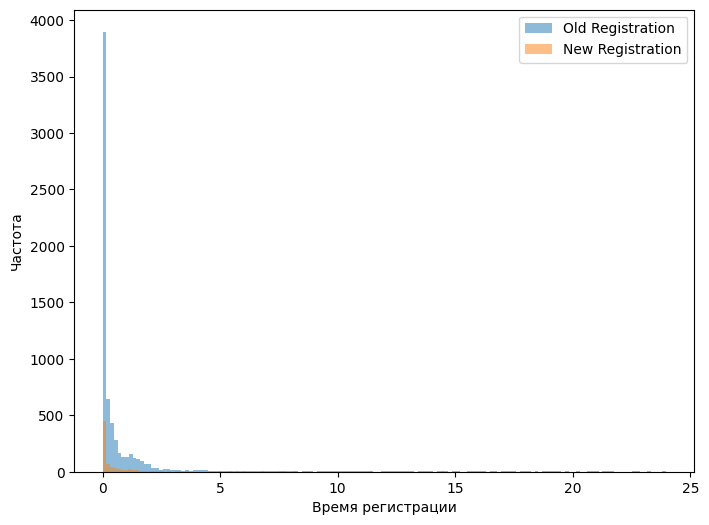

In [348]:
plt.figure(figsize=(8, 6))

plt.hist(old_registration_times['registration_time'].dt.total_seconds() / (3600), bins=150, alpha=0.5, label='Old Registration')

plt.hist(new_registration_times['registration_time'].dt.total_seconds() / (3600), bins=150, alpha=0.5, label='New Registration')

plt.xlabel('Время регистрации')
plt.ylabel('Частота')
plt.legend()

plt.show()

In [355]:
# Преобразование значения Timedelta в секунды
old = old_registration_data['registration_time'].drop_duplicates().dt.total_seconds()
new = new_registration_data['registration_time'].drop_duplicates().dt.total_seconds()
print(len(old),len(new))

mean_old_registration_time = old.mean()
mean_new_registration_time = new.mean()

# Проведение t-теста для сравнения средних значений
t_statistic, p_value = stats.ttest_ind(old, new, equal_var=False)

# Вывод результатов
print("Среднее время до успешной регистрации для старой формы: {:.2f}".format(mean_old_registration_time/(60)))
print("Среднее время до успешной регистрации для новой формы: {:.2f}".format(mean_new_registration_time/(60)))
print("\nРезультаты статистического теста:")
print("T-статистика: {:.4f}".format(t_statistic))
print("P-значение: {:.4f}".format(p_value))

801 801
Среднее время до успешной регистрации для старой формы: 62.67
Среднее время до успешной регистрации для новой формы: 73.26

Результаты статистического теста:
T-статистика: -1.1189
P-значение: 0.2634


p-value > 0.05, то есть таким образом, время отличается незначимо. Для проверки был использован критерий Стьюдента (t-критерий) о статистической значимости различий между средними значениями двух групп.

Таким образом, введение новой формы регистации не дает значимого выигрыша ни в количестве регистаций, ни во времени регистрации.

Вывод по работе:
 - исходная выборка несбалансирована, большую часть занимают пользователи, которые не заходили на форму ренегистрации(101110), затем пользователи, которые посетили старую форму регистрации (19458), а затем по новой форме (2106). 
 - Видим, что наибольшее количество обращений к странице было в январе, затем количество запросов падает, в феврале и марте примерно на одном уровне, затем в апреле резкое падение из-за неполного набора данных за месяц.
- Заметна одинаковая внутримесяная тенденция. Количество обращений к странице падает к середине недели и возрастает к концу недели.
- Внутри дня наибольшая активность после 16.00. Наименьшее количество обращений во время рабочего дня (с 8.00 до 16.00).
- Новая форма регистрации не дает выигрыша ни во времени, ни в количестве успешных реистраций. 